# Testing emulator performance

This notebook evaluates the performance of trained looti emulators for a set of cosmological observables

Import Packages

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from looti import dictlearn as dcl
from looti import datahandle as dhl

Specify the path to the folder containing the saved data set and emulator for all observables

In [2]:
load_path = '../interpolators/redshift_0/'

## Linear power spectrum $P_{lin}$

Load the data set and the trained emulator

In [3]:
emulation_data = pickle.load(open(load_path + 'pca9_nrsts200_aniso_data.sav', 'rb'))
intobj = pickle.load(open(load_path + 'pca9_nrsts200_aniso.sav', 'rb'))

In [4]:
n_train = emulation_data.train_size
npca = intobj.ncomp
data_type = emulation_data.data_type
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))
fgrid = emulation_data.fgrid

In [5]:
df_ext = pd.read_csv('../data/rwth_output/mg_camb_lhs_log10fR0/Plin_z0.csv', index_col=list(range(14)))
df_ref = pd.read_csv('../data/rwth_output/mg_camb_lhs_log10fR0/Plin_z0_ref.csv', index_col=list(range(2)))

In [6]:
n_plot_train = 10

In [7]:
xtrain = intobj.trainspace_normed
truth_normed_pcas_train = intobj.representation
prediction_pca_train, std_pca_train = intobj.gp_regressor.predict(xtrain, return_std=True)

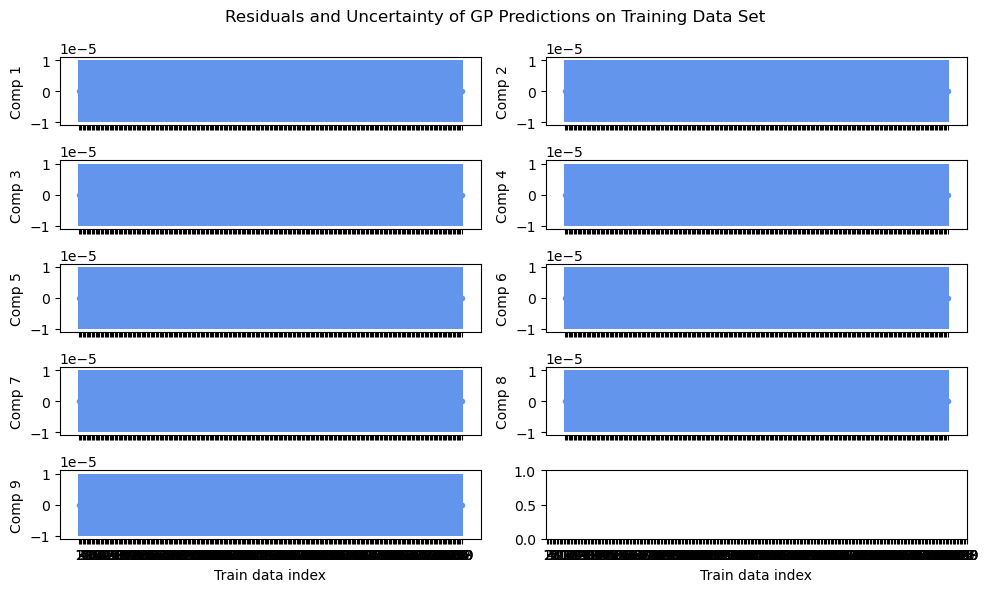

In [8]:
n_test = n_plot_train
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))

fig.suptitle('Residuals and Uncertainty of GP Predictions on Training Data Set')

for comp in range(npca):
    axs.ravel()[comp].errorbar(grid, 
                 truth_normed_pcas_train[:n_plot_train][:,comp]-prediction_pca_train[:n_plot_train][:,comp], 
                 yerr=std_pca_train[:n_plot_train][:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    axs.ravel()[comp].hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    axs.ravel()[comp].set_ylabel("Comp %i" %(comp+1))
    axs.ravel()[comp].set_xticks(list(range(1,n_test+1)))
    axs.ravel()[comp].set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Train data index')
    axs[-1, i].set_xticks(list(range(1, n_test+1)))
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [9]:
binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std

In [10]:
nparam = emulation_data.num_parameters + int(emulation_data.multiple_z)
if emulation_data.multiple_z:
    params = ['z']
else:
    params = []
params += list(emulation_data.paramnames_dict.values())

In [11]:
test_indices = emulation_data.test_splitdict[0]
truth_spectrum = emulation_data.df_ext.loc['Plin'].values[test_indices]
ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()

truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.reconstruct_data(emulation_data.test_samples, pca_norm=True)

In [97]:
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [98]:
truth_normed_pcas_list = []

for ii in range(emulation_data.test_samples.shape[0]):
    indexvalues = emulation_data.test_samples[ii]
    index_list = emulation_data.data_type, 0.0, params[0], indexvalues[0], params[1], indexvalues[1], params[2], indexvalues[2], params[3], indexvalues[3], params[4], indexvalues[4], params[5], indexvalues[5]

    truth_spectrum_test = emulation_data.df_ext.loc[index_list].values.flatten()
    
    ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()



    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

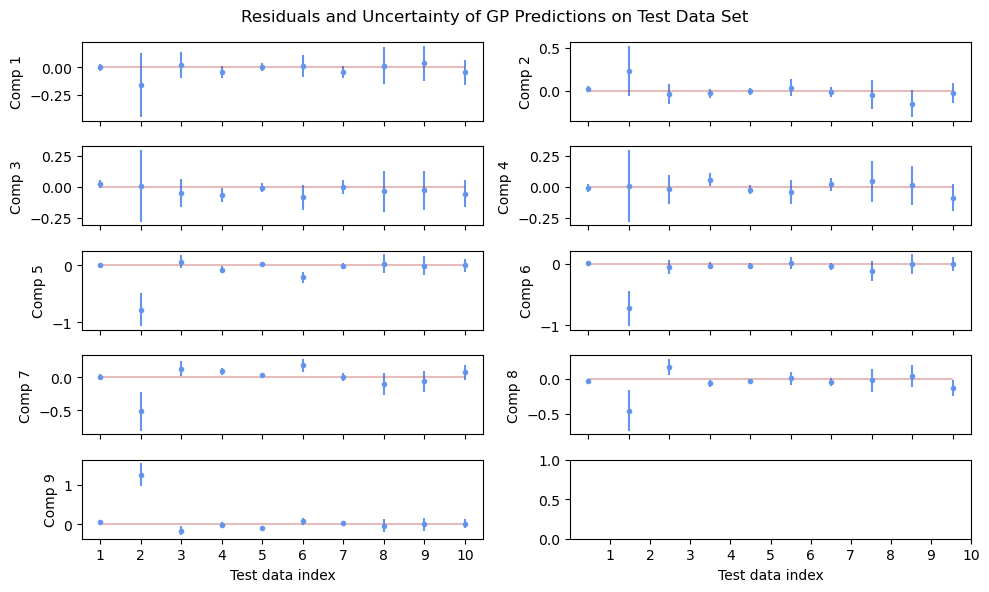

In [99]:
n_test = emulation_data.test_samples.shape[0]
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp in range(npca):
    axs.ravel()[comp].errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    axs.ravel()[comp].hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    axs.ravel()[comp].set_ylabel("Comp %i" %(comp+1))
    axs.ravel()[comp].set_xticks(list(range(1,n_test+1)))
    axs.ravel()[comp].set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticks(list(range(1, n_test+1)))
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [103]:
plot_index = 1

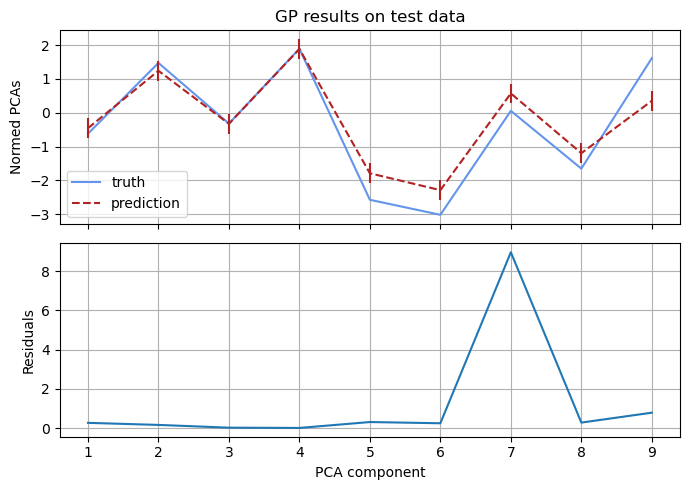

In [104]:
fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

ax[0].plot(np.linspace(1, npca, npca), truth_normed_pcas[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals_pca = np.abs(1- (prediction_pca_test[plot_index]/truth_normed_pcas[plot_index]))
ax[1].plot(np.linspace(1, npca, npca), residuals_pca)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

Text(0, 0.5, 'Residuals')

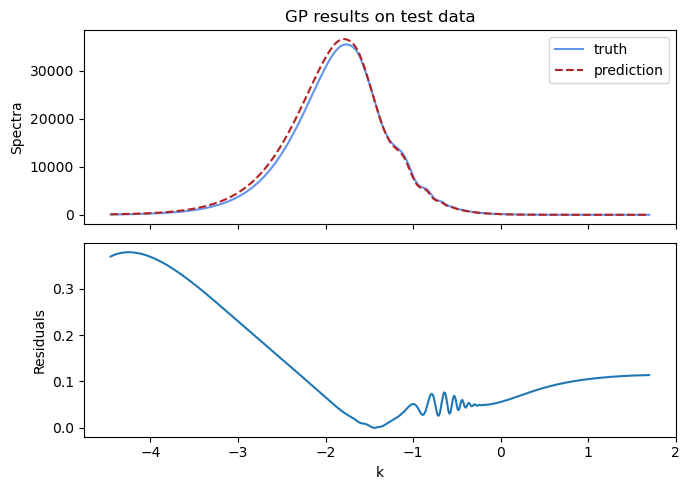

In [105]:
prediction_spectrum_normed_test = intobj.reconstruct_data(emulation_data.test_samples, pca_norm=True)
prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref_spectrum
# prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test, emulation_data)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(fgrid, truth_spectrum[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(fgrid, prediction_spectrum_test[plot_index].flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test[plot_index].flatten() / truth_spectrum[plot_index])
ax[1].plot(fgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')

## Linear power spectrum $P_{nonlin}$

In [71]:
emulation_data = pickle.load(open(load_path + 'Pnonlin_data.sav', 'rb'))
intobj = pickle.load(open(load_path + 'Pnonlin.sav', 'rb'))

In [72]:
n_train = emulation_data.train_size
npca = intobj.ncomp
data_type = emulation_data.data_type
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))
fgrid = emulation_data.fgrid

In [28]:
# data_i4c = pickle.load(open('../interpolators/mg_camb_lhs_log10fR0/Pnonlin_data.sav', 'rb'))
# df_raw = pd.read_csv('../data/rwth_output/mg_camb_lhs_log10fR0/Pnonlin.csv', index_col=list(range(14)))
# df_ref = pd.read_csv('../data/rwth_output/mg_camb_lhs_log10fR0/Pnonlin_ref.csv', index_col=list(range(2)))

# kgrid = df_raw.loc['k_grid'].values.flatten()
# spectra_raw = df_raw.loc['Plin'].values
# spectra_ref = df_ref.loc['Plin'].values
# spectra_normed = data_i4c.matrix_ratios_raw
# spectra_stand = data_i4c.matrix_ratios_dict

# colors_raw = plt.cm.coolwarm(np.linspace(0, 1, spectra_raw.shape[0]))
# colors_ref = plt.cm.coolwarm(np.linspace(0, 1, 2))
# fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# for sraw, color in zip(spectra_raw, colors_raw):
#     axs[0].semilogx(kgrid, sraw, color=color)
# for sref, color in zip(spectra_ref, colors_ref):
#     axs[1].semilogx(kgrid, sref, color=color)
# for snor, color in zip(spectra_normed, colors_raw):
#     axs[2].semilogx(kgrid, snor, color=color)
# for ssta, color in zip(spectra_stand, colors_raw):
#     axs[3].semilogx(kgrid, ssta, color=color)
    
# for i in range(4):
#     axs[i].set_xlabel('k')

# axs[0].set_title('Raw Spectra')
# axs[1].set_title('Reference Spectra')
# axs[2].set_title('Normalized by Reference')
# axs[3].set_title('Normalized by Mean & Std')

# fig.suptitle('Input4cast Camb Data at z=0', fontsize=16)
# plt.tight_layout()

Text(0.5, 1.0, 'spectra')

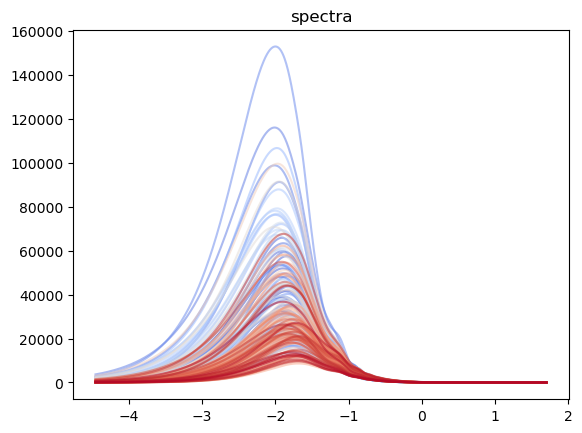

In [29]:
spectra = emulation_data.df_ext.loc[data_type].values
for i, (spec, color) in enumerate(zip(spectra, colors)):
    # if i == 0:
    #     plt.plot(fgrid, spec, c=color, alpha=0.5, label='z= %i' %emulation_data.z_requested[i])
    plt.plot(fgrid, spec, c=color, alpha=0.5)
plt.title('spectra')
# plt.legend()

TRAINING DATA: (202, 800)


Text(0.5, 1.0, 'spectra normed')

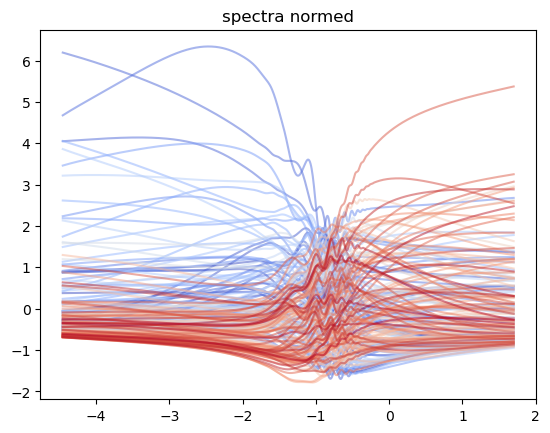

In [30]:
trainspace_matrix = intobj.trainspace_mat
print('TRAINING DATA:', trainspace_matrix.shape)
for spec, color in zip(trainspace_matrix, colors):
    plt.plot(fgrid, spec, c=color, alpha=0.5)
plt.title('spectra normed')

PCA RAW: (202, 8)


Text(0.5, 1.0, 'pca')

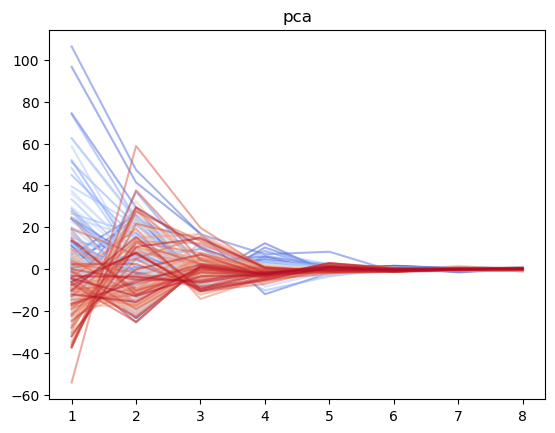

In [31]:
pca_raw = intobj.pca.fit(trainspace_matrix).transform(trainspace_matrix)
print('PCA RAW:', pca_raw.shape)
for pcar, color in zip(pca_raw, colors):
    plt.plot(np.linspace(1, npca, npca), pcar, c=color, alpha=0.5)
plt.title('pca')

PCA: (202, 8)


Text(0.5, 1.0, 'pca normed')

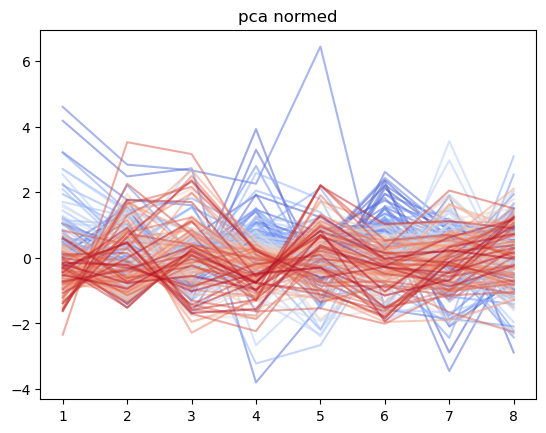

In [32]:
pca_test = intobj.representation
print('PCA:', pca_test.shape)
for pca, color in zip(pca_test, colors):
    plt.plot(np.linspace(1, npca, npca), pca, c=color, alpha=0.5)
plt.title('pca normed')

Text(0, 0.5, 'Normed Input Values')

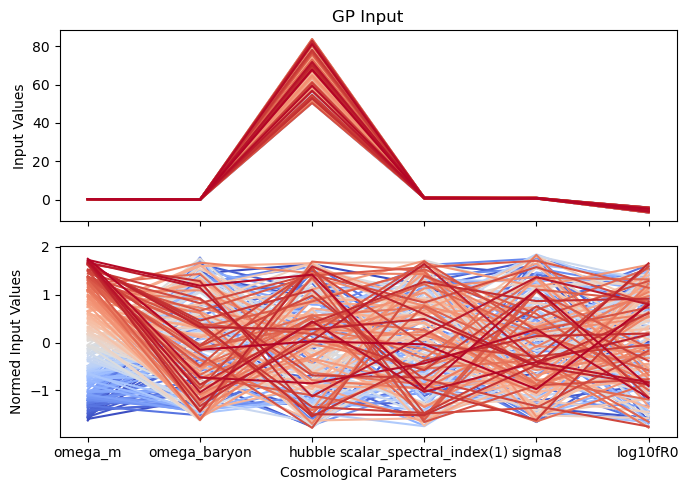

In [33]:
nparam = emulation_data.num_parameters + int(emulation_data.multiple_z)
if emulation_data.multiple_z:
    params = ['z']
else:
    params = []
params += list(emulation_data.paramnames_dict.values())

trainspace_raw = intobj.trainspace
trainspace_normed = (trainspace_raw - trainspace_raw.mean(axis=0)) / trainspace_raw.std(axis=0)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

for tsr, color in zip(trainspace_raw, colors):
    ax[0].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[0].set_ylabel('Input Values')
ax[0].set_xticklabels([])
ax[0].set_title('GP Input')


for tsr, color in zip(trainspace_normed, colors):
    ax[1].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[1].set_xticks(list(range(1, nparam+1)))
ax[1].set_xticklabels(params)
ax[1].set_xlabel('Cosmological Parameters')
ax[1].set_ylabel('Normed Input Values')

In [56]:
plot_index = 0

In [57]:
params

['z', 'w0_fld', 'wa_fld', 'Omega_m', 'Omega_b', 'h', 'n_s', 'A_s']

In [58]:
indexvalues = emulation_data.test_samples[plot_index]

binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std

if emulation_data.multiple_z:
    ref = emulation_data.df_ref.loc[data_type, 0.0]
else:
    ref = emulation_data.df_ref.loc[data_type, indexvalues[0]]

In [59]:
index_list = emulation_data.data_type, indexvalues[0],params[1], indexvalues[1],params[2], indexvalues[2],params[3], indexvalues[3],params[4], indexvalues[4],params[5], indexvalues[5],params[6], indexvalues[6],params[7], indexvalues[7]

truth_spectrum = emulation_data.df_ext.loc[index_list]

ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()
# ref_spectrum = 1

truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]

In [60]:
truth_spectrum_test = emulation_data.df_ext.loc[index_list]


ref_spectrum = emulation_data.df_ref.loc[data_type,  0.0].values.flatten()

truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [61]:
truth_normed_pcas_list = []

for ii in range(emulation_data.test_samples.shape[0]):
    indexvalues = emulation_data.test_samples[ii]
    truth_spectrum_test = emulation_data.df_ext.loc[index_list]
    
    ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()



    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

IndexError: index 7 is out of bounds for axis 1 with size 7

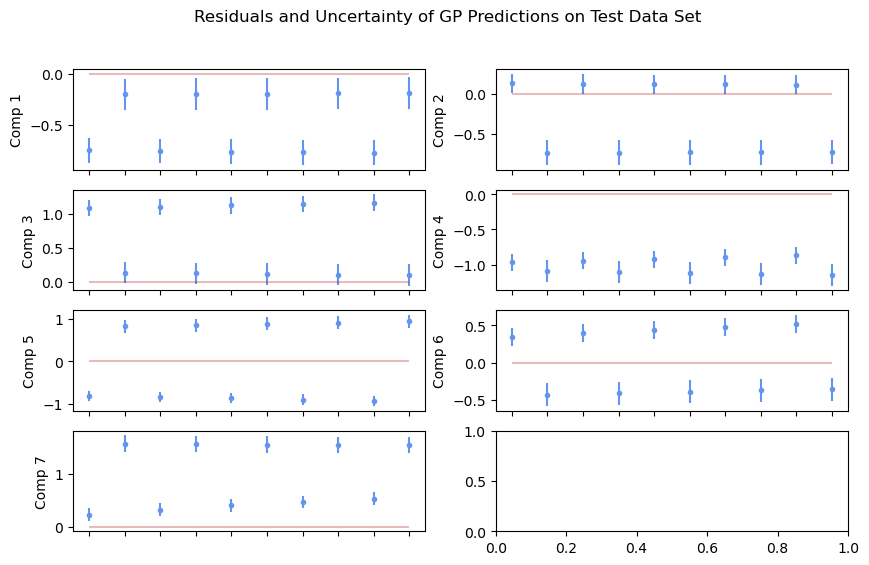

In [62]:
n_test = emulation_data.test_samples.shape[0]
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp, ax in enumerate(axs.ravel()):
    ax.errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    ax.hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    ax.set_ylabel("Comp %i" %(comp+1))
    ax.set_xticks(list(range(1,n_test+1)))
    ax.set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

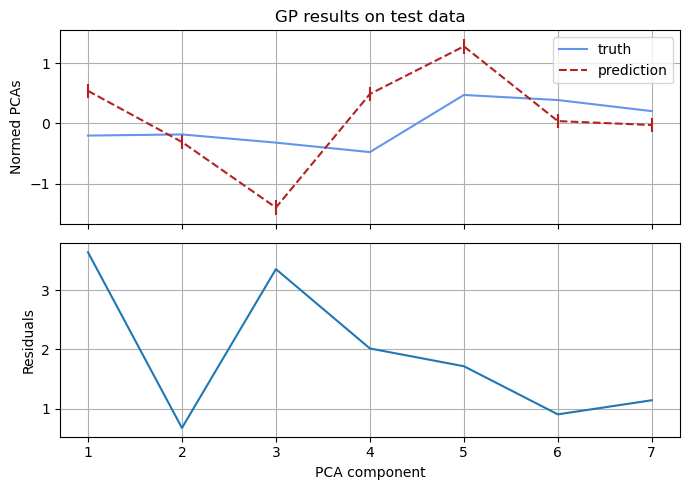

In [63]:
indexvalues = emulation_data.test_samples[plot_index]
truth_spectrum_test = emulation_data.df_ext.loc[index_list].values.flatten()

ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()


truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)
# prediction_pca_test = intobj.interpolated_atoms(xtest)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals_pca = np.abs(1- (prediction_pca_test[plot_index]/truth_pca_test))
ax[1].plot(np.linspace(1, npca, npca), residuals_pca)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

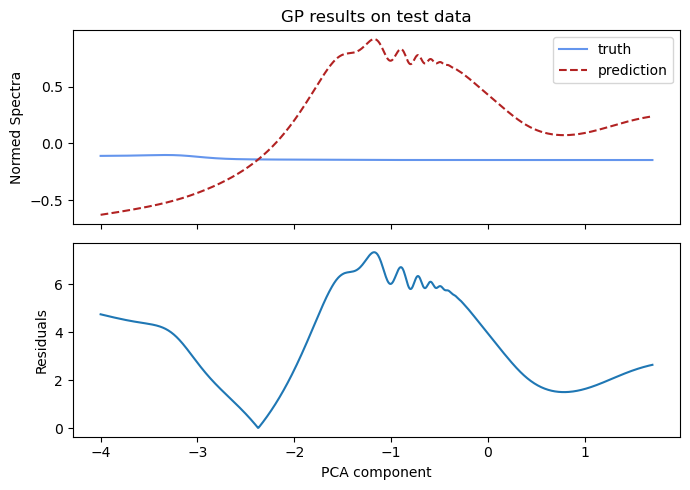

In [64]:
prediction_spectrum_normed_test = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]
# prediction_spectrum_normed = ratios_predicted[tuple(emulation_data.test_samples[plot_index])]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(fgrid, truth_spectrum_normed_test, c='cornflowerblue', label='truth')
ax[0].plot(fgrid, prediction_spectrum_normed_test, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
# ax[0].hlines(0, 1, 2499, color='black', alpha=0.3)

residuals_norm = np.abs(1 - prediction_spectrum_normed_test / truth_spectrum_normed_test)
ax[1].plot(fgrid, residuals_norm)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
plt.show()

Text(0, 0.5, 'Residuals')

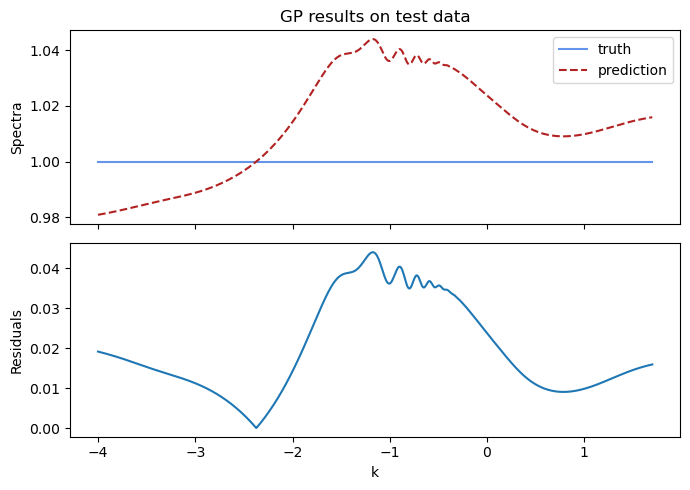

In [65]:
prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref_spectrum
# prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test, emulation_data)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(fgrid, truth_spectrum_test, c='cornflowerblue', label='truth')
ax[0].plot(fgrid, prediction_spectrum_test.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test.flatten() / truth_spectrum_test)
ax[1].plot(fgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')

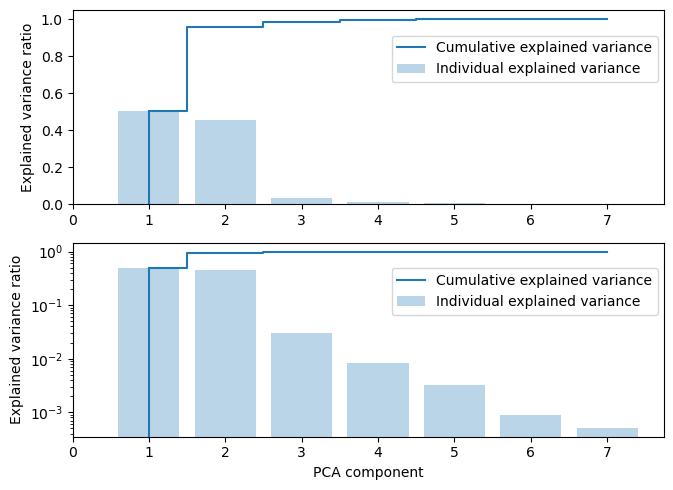

In [66]:
pca = intobj.pca

X_train_pca = pca.fit_transform(trainspace_matrix)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig, ax = plt.subplots(2, figsize=(7, 5))
ax[0].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[0].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[0].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xticks(list(range(npca+1)))
ax[0].legend(loc=(0.54, 0.63))

ax[1].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[1].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[1].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_xlabel('PCA component')
ax[1].set_yscale('log')
ax[1].set_xticks(list(range(npca+1)))
ax[1].legend(loc=(0.54, 0.63))
plt.tight_layout()
plt.show()

## Growth factor $D$

In [68]:
emulation_data = pickle.load(open(load_path + 'D_Growth_data.sav', 'rb'))
intobj = pickle.load(open(load_path + 'D_Growth.sav', 'rb'))

In [69]:
n_train = emulation_data.train_size
npca = intobj.ncomp
data_type = emulation_data.data_type
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))
fgrid = emulation_data.fgrid

Text(0.5, 1.0, 'spectra')

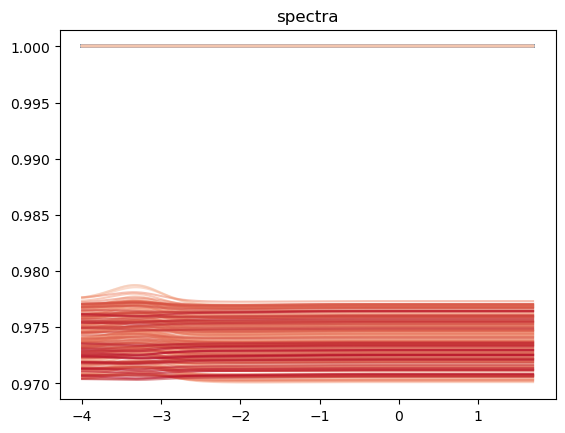

In [70]:
spectra = emulation_data.df_ext.loc[data_type].values
for i, (spec, color) in enumerate(zip(spectra, colors)):
    # if i == 0:
    #     plt.plot(fgrid, spec, c=color, alpha=0.5, label='z= %i' %emulation_data.z_requested[i])
    plt.plot(fgrid, spec, c=color, alpha=0.5)
plt.title('spectra')
# plt.legend()

TRAINING DATA: (510, 800)


Text(0.5, 1.0, 'spectra normed')

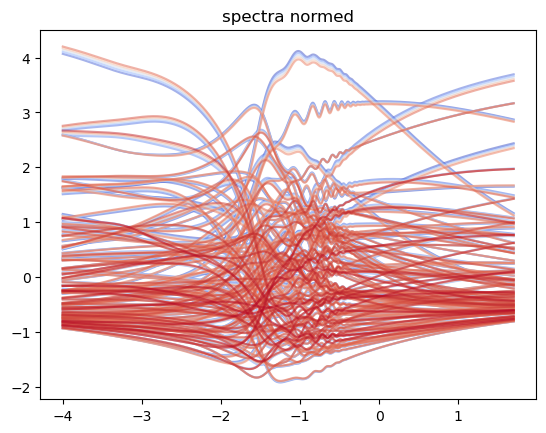

In [ ]:
trainspace_matrix = intobj.trainspace_mat
print('TRAINING DATA:', trainspace_matrix.shape)
for spec, color in zip(trainspace_matrix, colors):
    plt.plot(fgrid, spec, c=color, alpha=0.5)
plt.title('spectra normed')

PCA RAW: (510, 9)


Text(0.5, 1.0, 'pca')

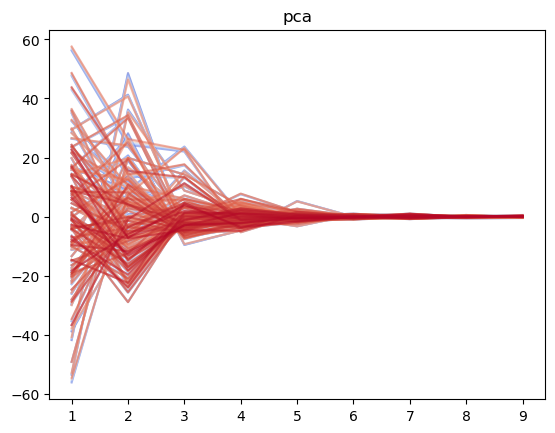

In [ ]:
pca_raw = intobj.pca.fit(trainspace_matrix).transform(trainspace_matrix)
print('PCA RAW:', pca_raw.shape)
for pcar, color in zip(pca_raw, colors):
    plt.plot(np.linspace(1, npca, npca), pcar, c=color, alpha=0.5)
plt.title('pca')

PCA: (510, 9)


Text(0.5, 1.0, 'pca normed')

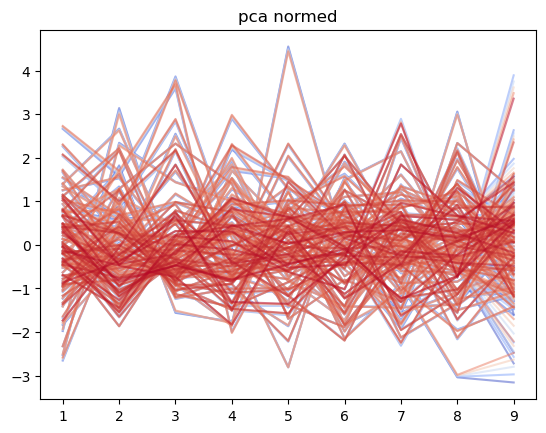

In [ ]:
pca_test = intobj.representation
print('PCA:', pca_test.shape)
for pca, color in zip(pca_test, colors):
    plt.plot(np.linspace(1, npca, npca), pca, c=color, alpha=0.5)
plt.title('pca normed')

Text(0, 0.5, 'Normed Input Values')

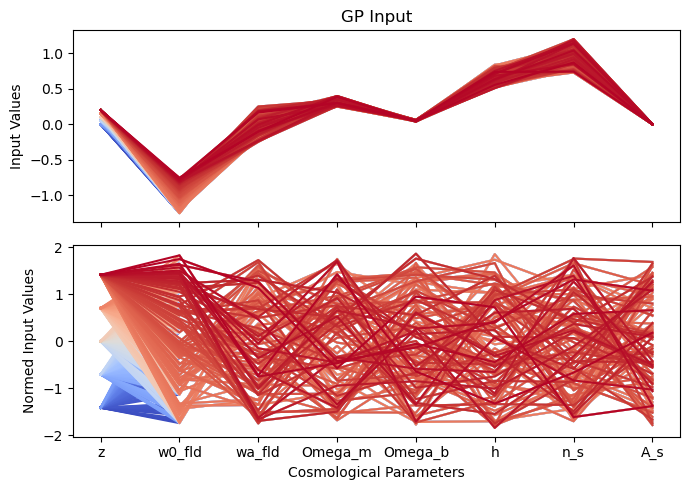

In [ ]:
nparam = emulation_data.num_parameters + int(emulation_data.multiple_z)
if emulation_data.multiple_z:
    params = ['z']
else:
    params = []
params += list(emulation_data.paramnames_dict.values())

trainspace_raw = intobj.trainspace
trainspace_normed = (trainspace_raw - trainspace_raw.mean(axis=0)) / trainspace_raw.std(axis=0)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

for tsr, color in zip(trainspace_raw, colors):
    ax[0].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[0].set_ylabel('Input Values')
ax[0].set_xticklabels([])
ax[0].set_title('GP Input')


for tsr, color in zip(trainspace_normed, colors):
    ax[1].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[1].set_xticks(list(range(1, nparam+1)))
ax[1].set_xticklabels(params)
ax[1].set_xlabel('Cosmological Parameters')
ax[1].set_ylabel('Normed Input Values')

In [ ]:
plot_index = 0

In [ ]:
params

['z', 'w0_fld', 'wa_fld', 'Omega_m', 'Omega_b', 'h', 'n_s', 'A_s']

In [ ]:
indexvalues = emulation_data.test_samples[plot_index]

binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std

if emulation_data.multiple_z:
    ref = emulation_data.df_ref.loc[data_type, 0.0]
else:
    ref = emulation_data.df_ref.loc[data_type, indexvalues[0]]

In [ ]:
index_list = emulation_data.data_type, indexvalues[0],params[1], indexvalues[1],params[2], indexvalues[2],params[3], indexvalues[3],params[4], indexvalues[4],params[5], indexvalues[5],params[6], indexvalues[6],params[7], indexvalues[7]

truth_spectrum = emulation_data.df_ext.loc[index_list]

ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()
# ref_spectrum = 1

truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]

In [ ]:
truth_spectrum_test = emulation_data.df_ext.loc[index_list]


ref_spectrum = emulation_data.df_ref.loc[data_type,  0.0].values.flatten()

truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [ ]:
truth_normed_pcas_list = []

for ii in range(emulation_data.test_samples.shape[0]):
    indexvalues = emulation_data.test_samples[ii]
    truth_spectrum_test = emulation_data.df_ext.loc[index_list]
    
    ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()



    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

IndexError: index 9 is out of bounds for axis 1 with size 9

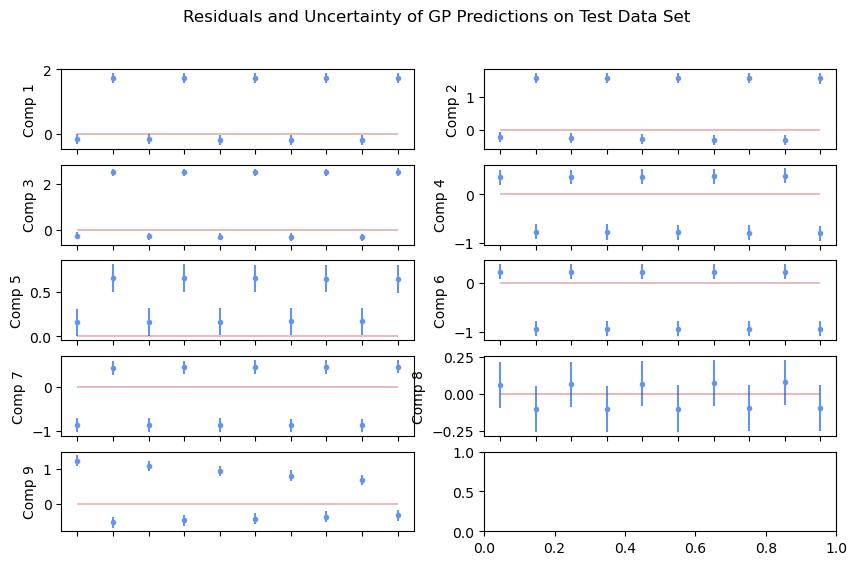

In [ ]:
n_test = emulation_data.test_samples.shape[0]
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp, ax in enumerate(axs.ravel()):
    ax.errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    ax.hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    ax.set_ylabel("Comp %i" %(comp+1))
    ax.set_xticks(list(range(1,n_test+1)))
    ax.set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

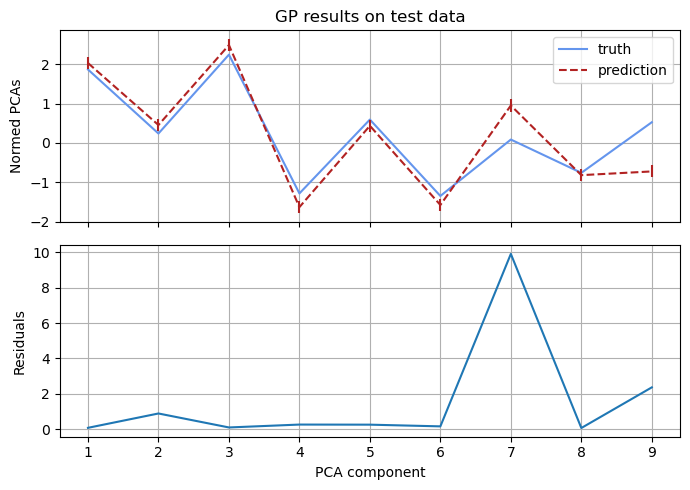

In [ ]:
indexvalues = emulation_data.test_samples[plot_index]
truth_spectrum_test = emulation_data.df_ext.loc[index_list].values.flatten()

ref_spectrum = emulation_data.df_ref.loc[data_type, 0.0].values.flatten()


truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)
# prediction_pca_test = intobj.interpolated_atoms(xtest)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals_pca = np.abs(1- (prediction_pca_test[plot_index]/truth_pca_test))
ax[1].plot(np.linspace(1, npca, npca), residuals_pca)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

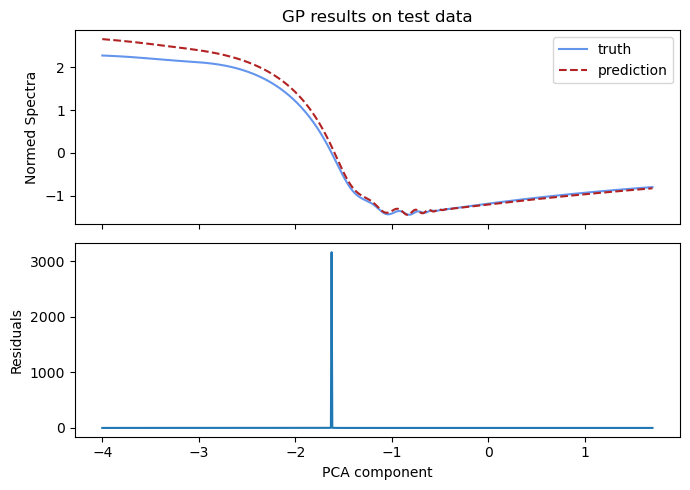

In [ ]:
prediction_spectrum_normed_test = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]
# prediction_spectrum_normed = ratios_predicted[tuple(emulation_data.test_samples[plot_index])]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(fgrid, truth_spectrum_normed_test, c='cornflowerblue', label='truth')
ax[0].plot(fgrid, prediction_spectrum_normed_test, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
# ax[0].hlines(0, 1, 2499, color='black', alpha=0.3)

residuals_norm = np.abs(1 - prediction_spectrum_normed_test / truth_spectrum_normed_test)
ax[1].plot(fgrid, residuals_norm)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
plt.show()

Text(0, 0.5, 'Residuals')

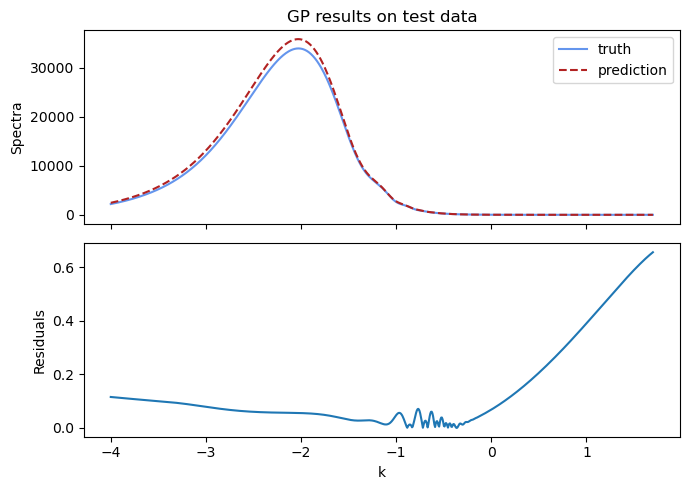

In [ ]:
prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref_spectrum
# prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test, emulation_data)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(fgrid, truth_spectrum_test, c='cornflowerblue', label='truth')
ax[0].plot(fgrid, prediction_spectrum_test.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test.flatten() / truth_spectrum_test)
ax[1].plot(fgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')

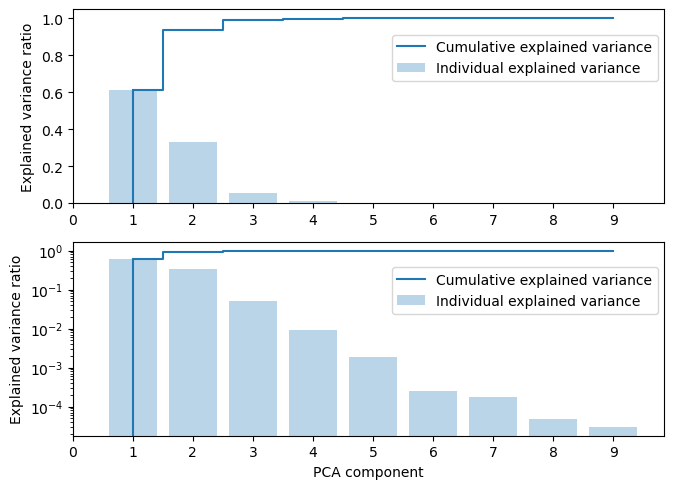

In [ ]:
pca = intobj.pca

X_train_pca = pca.fit_transform(trainspace_matrix)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig, ax = plt.subplots(2, figsize=(7, 5))
ax[0].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[0].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[0].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xticks(list(range(npca+1)))
ax[0].legend(loc=(0.54, 0.63))

ax[1].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[1].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[1].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_xlabel('PCA component')
ax[1].set_yscale('log')
ax[1].set_xticks(list(range(npca+1)))
ax[1].legend(loc=(0.54, 0.63))
plt.tight_layout()
plt.show()